In [ ]:
!pip install matplotlib scikit-learn torch pandas


Import Library

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



**Data Preprocessing**

In [69]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti dengan path file kamu
df = pd.read_csv('/content/drive/MyDrive/Sales_Forecasting/RetailSales.csv')
df.head()
# Konversi kolom tanggal
df['Date'] = pd.to_datetime(df['data'])

# Ekstraksi fitur waktu
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Tambahkan lag dan moving average dari penjualan (venda)
df['Sales_Lag1'] = df['venda'].shift(1)
df['Sales_Lag7'] = df['venda'].shift(7)
df['Sales_MA7'] = df['venda'].rolling(7).mean()

# Hapus baris yang mengandung NaN akibat operasi shift/rolling
df.dropna(inplace=True)

# Buat dataset fitur dan target
features = df[['preco', 'estoque', 'Month', 'Day', 'DayOfWeek', 'is_weekend',
               'Sales_Lag1', 'Sales_Lag7', 'Sales_MA7', 'WeekOfYear', 'Quarter']]
target = df['venda'].values.reshape(-1, 1)

# Normalisasi
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Normalisasi and Sequence**

In [70]:
from sklearn.model_selection import train_test_split
import torch

# Fungsi membuat dataset time series
def create_dataset(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i+look_back].flatten())  # ANN: flatten tiap sequence
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# Buat data sequence
X_seq, y_seq = create_dataset(X_scaled, y_scaled, look_back=30)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# Konversi ke Tensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


**Model Definition**

In [72]:
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Inisialisasi model
input_size = X_train_tensor.shape[1]  # jumlah fitur input
model = ANNModel(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**Training Model**

In [73]:
epochs = 100  # Ubah jika ingin eksperimen

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")




Epoch 10/100, Loss: 0.0166
Epoch 20/100, Loss: 0.0153
Epoch 30/100, Loss: 0.0141
Epoch 40/100, Loss: 0.0129
Epoch 50/100, Loss: 0.0116
Epoch 60/100, Loss: 0.0105
Epoch 70/100, Loss: 0.0094
Epoch 80/100, Loss: 0.0086
Epoch 90/100, Loss: 0.0079
Epoch 100/100, Loss: 0.0070


**Evaluasi Model**

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_tensor).numpy()
    actual_scaled = y_test_tensor.numpy()

# Kembalikan ke skala asli
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(actual_scaled)

# Hitung metrik evaluasi
mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)
r2 = r2_score(actual, pred)

print(f"\n📊 Evaluasi Model ANN:")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"R²   : {r2:.4f}")



📊 Evaluasi Model ANN:
MSE  : 7772.3818
RMSE : 88.1611
MAE  : 63.3991
R²   : 0.0487


**Visualisasi Hasil**

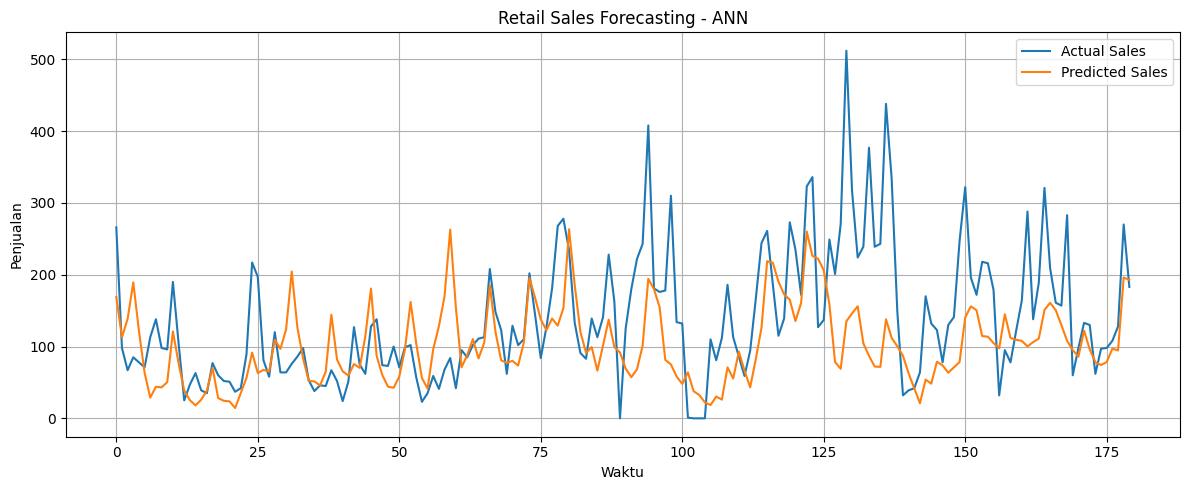

In [79]:
plt.figure(figsize=(12,5))
plt.plot(actual, label='Actual Sales')
plt.plot(pred, label='Predicted Sales')
plt.title('Retail Sales Forecasting - ANN')
plt.xlabel('Waktu')
plt.ylabel('Penjualan')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

